# Wavelet Transform

In this notebook we will experiment with the Wavelet Transform from PyWavelets and wrap it into a pylops operator

In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pywt

from scipy import misc
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import IRLS as IRLSpylops
from pylops.optimization.sparsity  import FISTA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1D Wavelet Transform

Let's start choosing a Wavelet and printing some info

In [2]:
pywt.wavelist(kind='discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

In [3]:
def format_array(arr):
    return "[%s]" % ", ".join(["%.14f" % x for x in arr])

wavelet = pywt.Wavelet('rbio1.1')
print(wavelet)
print(format_array(wavelet.dec_lo), format_array(wavelet.dec_hi))

Wavelet rbio1.1
  Family name:    Reverse biorthogonal
  Short name:     rbio
  Filters length: 2
  Orthogonal:     False
  Biorthogonal:   True
  Symmetry:       symmetric
  DWT:            True
  CWT:            False
[0.70710678118655, 0.70710678118655] [-0.70710678118655, 0.70710678118655]


We now apply the 1D Wavelet transform to 1d, 2d, and 3d arrays

nx = 50

x = np.random.normal(0, 1, nx)
y = pywt.wavedec(x, wavelet='haar', level=2, axis=0)
y, sl, sh = pywt.ravel_coeffs(y, axes=(0,))
print(x.shape)
print(y.shape)

y = pywt.unravel_coeffs(y, sl, sh, output_format='wavedec')
xadj = pywt.waverec(y, wavelet='haar', axis=0)
print(xadj.shape)

nx = 50

x = np.random.normal(0, 1, nx)
y = pywt.wavedecn(x, wavelet='haar', level=2, axes=(0, ))
y, sl, sh = pywt.ravel_coeffs(y, axes=(0,))
print(x.shape)
print(y.shape)

y = pywt.unravel_coeffs(y, sl, sh)
xadj = pywt.waverecn(y, wavelet='haar', axes=(0, ))
print(xadj.shape)

nx, ny, nz = 3, 4, 5
x = np.random.normal(0, 1, (nx, ny, nz))

y = pywt.wavedecn(x, wavelet='haar', mode='periodization', level=2, axes=(1, ))
y, sl, sh = pywt.ravel_coeffs(y, axes=(1,))
print(x.shape)
print(y.shape)

y = pywt.unravel_coeffs(y, sl, sh)
xadj = pywt.waverecn(y, wavelet='haar', mode='periodization', axes=(1, ))
print(xadj.shape)

nx, ny = 50, 100

x = np.random.normal(0, 1, (nx, ny))
y = pywt.wavedec2(x, wavelet='haar', level=2, axes=(0, 1))
y, sl = pywt.coeffs_to_array(y, axes=(0, 1))
print(x.shape)
print(y.shape)

y = pywt.array_to_coeffs(y, sl, output_format='wavedec2')
xadj = pywt.waverec2(y, wavelet='haar', axes=(0, 1))
print(xadj.shape)

In [4]:
W = DWT((10,), wavelet='db1')
dottest(W, W.shape[0], W.shape[1], verb=True)

Dot test passed, v^T(Opu)=1.928847 - u^T(Op^Tv)=1.928847


True

In [5]:
W = DWT((10, 20), dir=0, wavelet='haar')
dottest(W, W.shape[0], W.shape[1], verb=True)

Dot test passed, v^T(Opu)=3.400344 - u^T(Op^Tv)=3.400344


True

In [6]:
W = DWT((12, 8, 5), dir=1, level=2, wavelet='haar')
dottest(W, W.shape[0], W.shape[1], verb=True)

Dot test passed, v^T(Opu)=-49.118782 - u^T(Op^Tv)=-49.118782


True

In [7]:
W = DWT((3, 20, 5), dir=2, level=4, wavelet='haar')
dottest(W, W.shape[0], W.shape[1], verb=True)

Dot test passed, v^T(Opu)=4.082731 - u^T(Op^Tv)=4.082731


True

And here we check that the dottest passes for any choice of wavelet

In [8]:
nx = 10

for wav in pywt.wavelist(kind='discrete'):
    try:
        Wop = DWT(nx, wavelet=wav, level=5)
        dottest(Wop, Wop.shape[0], Wop.shape[1], verb=False)
        #print(wav)
    except:
        print('no '+ wav)

We can now create a sinusoidal signal and see what the wavelet transform look like. We will also truncate it and show that the first few coefficients contain most of the useful information

In [9]:
# Signal creation
N=200
dt=0.004
nfft=2**11
t = np.arange(N)*dt
f = np.fft.rfftfreq(nfft, dt)
ifreqs = [ 41, 25, 66]
freqs = f[ifreqs]

X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = 1
FFTop = 10*FFT(N, nfft=nfft, real=True)
x = FFTop.H*X

Text(0.5, 1.0, 'Reconstructed signal')

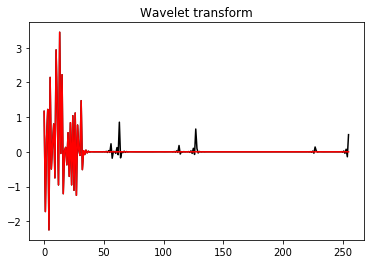

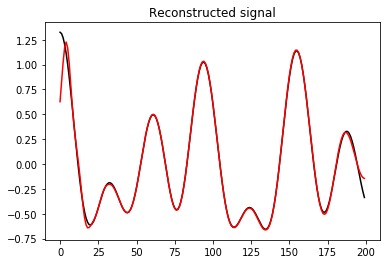

In [10]:
Wop = DWT((N, ), wavelet='dmey', level=5)

y = Wop * x
y1 = y.copy()
y1[40:] = 0
x1 = Wop.H * y1

plt.figure()
plt.plot(y, 'k')
plt.plot(y1, 'r')
plt.title('Wavelet transform')


plt.figure()
plt.plot(x, 'k')
plt.plot(x1, 'r')
plt.title('Reconstructed signal')

We can then use this wavelet as sparsity transform in a denoising process

FISTA optimization
-----------------------------------------------------------
The Operator Op has 200 rows and 256 cols
eps = 3.000000e-01	tol = 1.000000e-10	niter = 200
alpha = 9.860635e-01	thresh = 1.479095e-01
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   9.67863e-01   1.053e+00   1.071e+01   7.060e+00
     2   9.47269e-01   1.019e+00   1.060e+01   2.680e-01
     3   9.04821e-01   1.011e+00   1.049e+01   2.794e-01
     4   8.79515e-01   9.992e-01   1.039e+01   3.006e-01
     5   8.37326e-01   9.804e-01   1.034e+01   2.540e-01
     6   7.55773e-01   9.871e-01   1.029e+01   2.390e-01
     7   6.59042e-01   9.890e-01   1.025e+01   2.270e-01
     8   5.40349e-01   9.947e-01   1.020e+01   2.414e-01
     9   4.08144e-01   1.001e+00   1.015e+01   2.598e-01
    10   2.65909e-01   1.003e+00   1.010e+01   2.788e-01
    11   1.12315e-01   1.004e+00   1.004e+01   2.985e-01
    21   0.00000e+00   9.824e-01   9.914e+

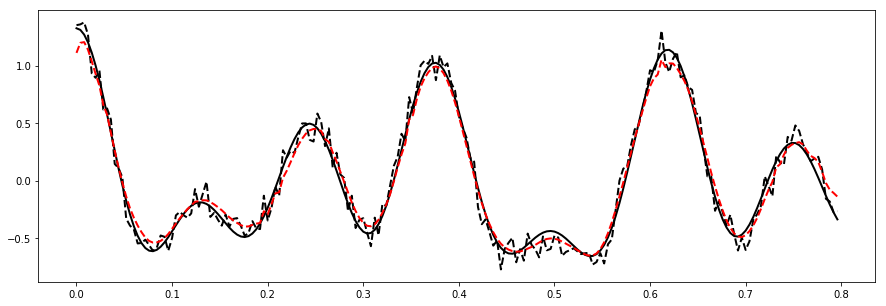

In [11]:
# Add noise
y = x + np.random.normal(0, 0.1, N)

# Denoise
Wop = DWT((N, ), wavelet='dmey', level=5)
xinv = FISTA(Wop.H, y, niter=200, eps=3e-1, show=True)[0]
xinv = Wop.H * xinv

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t, x, 'k' , LineWidth=2, label='model')
plt.plot(t, y, '--k' , LineWidth=2, label='data')
plt.plot(t, xinv, '--r' , LineWidth=2, label='data');

## 2D Wavelet Transform

nx, ny = 50, 100

x = np.random.normal(0, 1, (nx, ny))
y = pywt.wavedec2(x, wavelet='haar', level=2, axes=(0, 1))
y, sl, sh = pywt.ravel_coeffs(y, axes=(0, 1))
print(x.shape)
print(y.shape)

y = pywt.unravel_coeffs(y, sl, sh, output_format='wavedec2')
xadj = pywt.waverec2(y, wavelet='haar', axes=(0, 1))
print(xadj.shape)

nx, ny, nz = 4, 100, 20

x = np.random.normal(0, 1, (nx, ny, nz))
y = pywt.wavedec2(x, wavelet='haar', level=2, axes=(0, 1))
y, sl, sh = pywt.ravel_coeffs(y, axes=(0, 1))
print(x.shape)
print(y.shape)

y = pywt.unravel_coeffs(y, sl, sh, output_format='wavedec2')
xadj = pywt.waverec2(y, wavelet='haar', axes=(0, 1))
print(xadj.shape)

In [12]:
W = DWT2D((12, 50), dirs=(0, 1), level=5, wavelet='bior1.1')
dottest(W, W.shape[0], W.shape[1], verb=True)

Dot test passed, v^T(Opu)=2.144069 - u^T(Op^Tv)=2.144069


True

In [13]:
W = DWT2D((12, 50, 10), dirs=(0, 1), level=5, wavelet='bior1.1')
dottest(W, W.shape[0], W.shape[1], verb=True)

Dot test passed, v^T(Opu)=117.617258 - u^T(Op^Tv)=117.617258


True

In [14]:
W = DWT2D((12, 50, 10), dirs=(0, 2), level=5, wavelet='bior1.1')
dottest(W, W.shape[0], W.shape[1], verb=True)

Dot test passed, v^T(Opu)=94.657226 - u^T(Op^Tv)=94.657226


True

In [15]:
nx, ny = 2**5-4, 2**5-2
print(nx, ny)

for wav in pywt.wavelist(kind='discrete'):
    try:
        Wop = DWT2D((nx, ny), wavelet=wav, level=5)
        dottest(Wop, Wop.shape[0], Wop.shape[1], verb=False)
        #print(wav)
    except:
        print('no '+ wav)

28 30


(-0.5, 125.5, 125.5, -0.5)

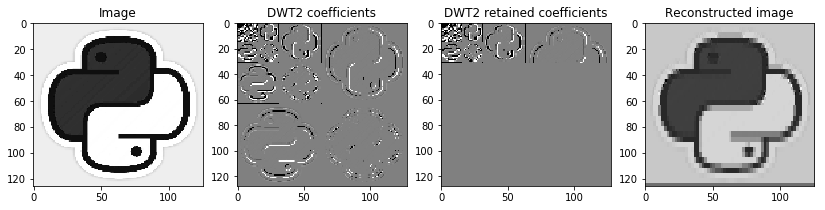

In [16]:
im = np.load('../data/python.npy')[::5, ::5, 0]

Nz, Nx = im.shape
Wop = DWT2D((Nz, Nx), wavelet='haar', level=5)
y = Wop * im.ravel()
yf = y.copy()
yf[len(y)//4:] = 0
iminv = Wop.H * yf
iminv = iminv.reshape(Nz, Nx)

fig, axs = plt.subplots(1, 4, figsize=(14, 3))
axs[0].imshow(im, cmap='gray')
axs[0].set_title('Image')
axs[0].axis('tight')
axs[1].imshow(y.reshape(Wop.dimsd), cmap='gray_r', vmin=-1e2, vmax=1e2)
axs[1].set_title('DWT2 coefficients')
axs[1].axis('tight')
axs[2].imshow(yf.reshape(Wop.dimsd), cmap='gray_r', vmin=-1e2, vmax=1e2)
axs[2].set_title('DWT2 retained coefficients')
axs[2].axis('tight')
axs[3].imshow(iminv, cmap='gray')
axs[3].set_title('Reconstructed image')
axs[3].axis('tight')

FISTA optimization
-----------------------------------------------------------
The Operator Op has 196608 rows and 262144 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 200
alpha = 1.001400e+00	thresh = 5.006998e-02
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   2.61400e+03   1.362e+07   1.374e+07   5.107e+04
     2   3.20815e+03   4.287e+06   4.421e+06   3.679e+03
     3   3.49614e+03   1.902e+06   2.043e+06   2.046e+03
     4   3.62498e+03   1.034e+06   1.179e+06   1.367e+03
     5   3.67749e+03   6.336e+05   7.818e+05   1.019e+03
     6   3.69697e+03   4.174e+05   5.676e+05   8.111e+02
     7   3.70387e+03   2.894e+05   4.409e+05   6.720e+02
     8   3.70661e+03   2.102e+05   3.625e+05   5.689e+02
     9   3.70809e+03   1.595e+05   3.122e+05   4.874e+02
    10   3.70912e+03   1.260e+05   2.788e+05   4.221e+02
    11   3.70988e+03   1.025e+05   2.551e+05   3.704e+02
    21   3.72133e+03   2.422e+04   1

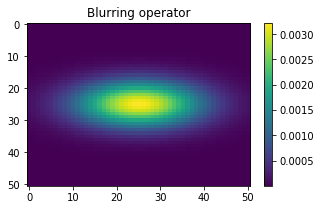

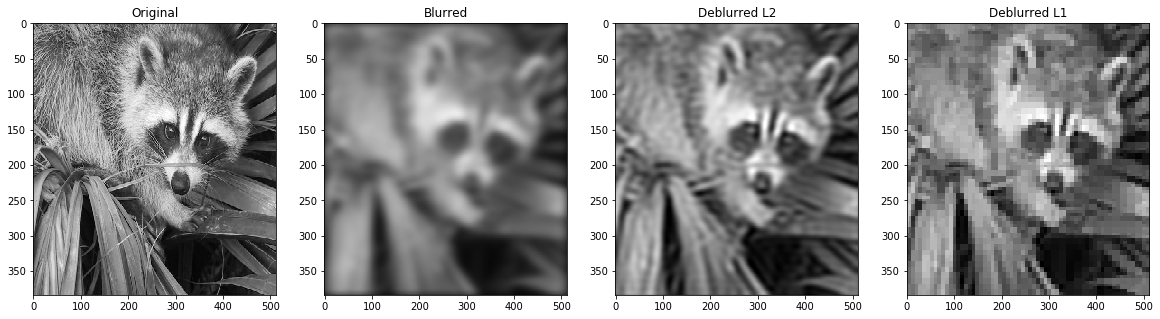

In [17]:
im = sp.misc.face()[::2, ::2, 0]

Nz, Nx = im.shape

# Blurring guassian operator
nh = [51, 51]
#hz = np.exp(-0.1*np.linspace(-(nh[0]//2), nh[0]//2, nh[0])**2)
#hx = np.exp(-0.03*np.linspace(-(nh[1]//2), nh[1]//2, nh[1])**2)
hz = sp.signal.gaussian(nh[0], 5, sym=True)
hx = sp.signal.gaussian(nh[1], 10, sym=True)
hz /= np.trapz(hz) # normalize the integral to 1
hx /= np.trapz(hx) # normalize the integral to 1
h = hz[:, np.newaxis] * hx[np.newaxis, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h)
ax.set_title('Blurring operator')
fig.colorbar(him, ax=ax)
ax.axis('tight')

Cop = Convolve2D(Nz * Nx, h=h,
                 offset=(nh[0] // 2,
                         nh[1] // 2),
                 dims=(Nz, Nx), dtype='float32')
Wop = DWT2D((Nz, Nx), wavelet='haar', level=5)

imblur = Cop * im.flatten()

imdeblur = NormalEquationsInversion(Cop, None, imblur, maxiter=50)

imdeblurl1 = FISTA(Cop * Wop.H, imblur, eps=1e-1, niter=200, show=True)[0]
imdeblurl1 = Wop.H * imdeblurl1

imblur = imblur.reshape(Nz, Nx)
imdeblur = imdeblur.reshape(Nz, Nx)
imdeblurl1 = imdeblurl1.reshape(Nz, Nx)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.imshow(im, cmap='gray', vmin=0, vmax=250)
ax1.axis('tight')
ax1.set_title('Original')
ax2.imshow(imblur, cmap='gray', vmin=0, vmax=250)
ax2.axis('tight')
ax2.set_title('Blurred');
ax3.imshow(imdeblur, cmap='gray', vmin=0, vmax=250)
ax3.axis('tight')
ax3.set_title('Deblurred L2');
ax4.imshow(imdeblurl1, cmap='gray', vmin=0, vmax=250)
ax4.axis('tight')
ax4.set_title('Deblurred L1');

Let's try now with seismic data

compression ration: 14.368778776584083
time taken: 0.025734901428222656


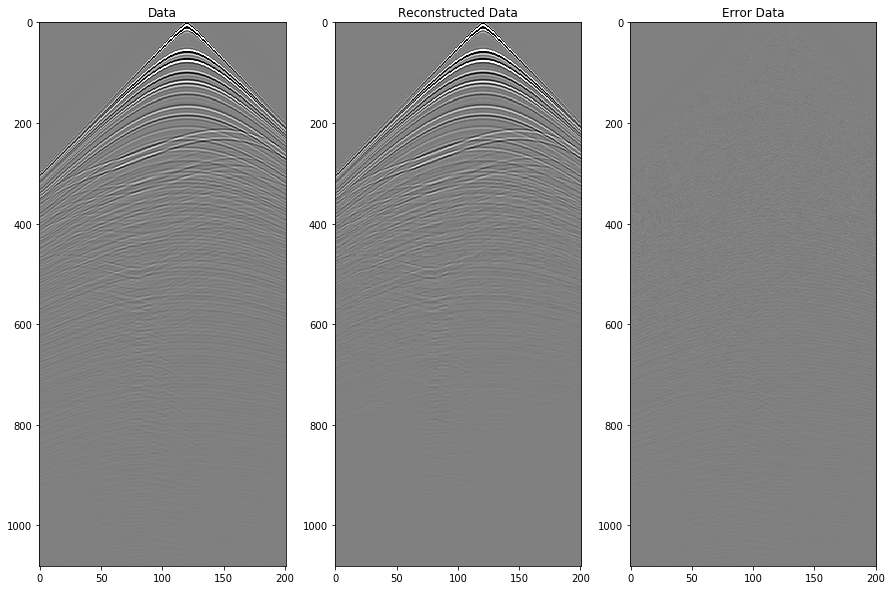

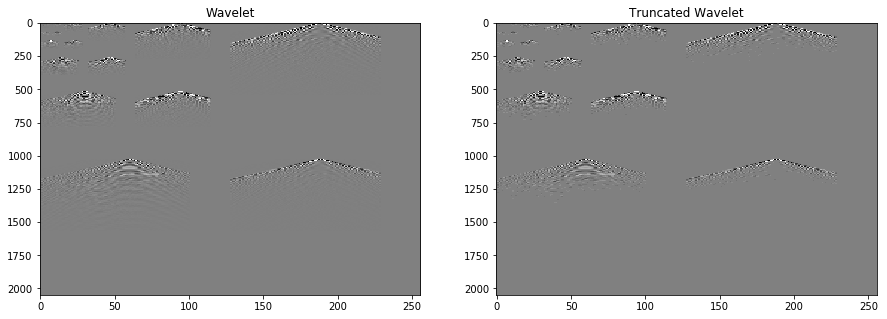

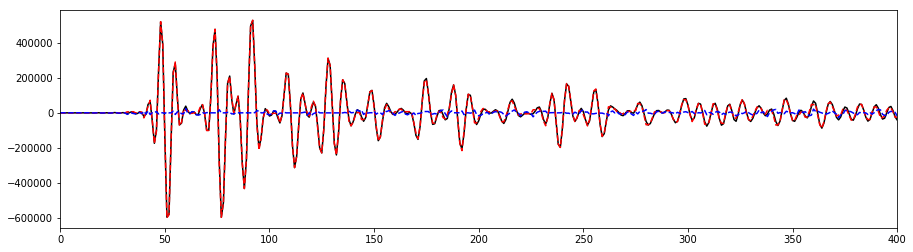

In [91]:
inputfile = '../data/updown/input.npz'
inputdata = np.load(inputfile)

d = inputdata['p'].T
nx, nt = d.shape

Wop = DWT2D((nx, nt), wavelet='db1', level=5)
D = Wop * d.ravel()

t0=time.time()
innzero = np.where(np.abs(D)>=0.004*np.abs(D).max())[0]
Df = np.zeros(Wop.shape[0])
Df[innzero] = D[innzero] 
dinv = Wop.H * Df
dinv = dinv.reshape(nx, nt)
print('compression ration:', D.size / (len(innzero)))
print('time taken:', time.time()-t0)

fig, axs = plt.subplots(1, 3, figsize=(15,10))
axs[0].imshow(d.T, cmap='gray', vmin=-0.1*d.max(), vmax=0.1*d.max())
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(dinv.T, cmap='gray', vmin=-0.1*d.max(), vmax=0.1*d.max())
axs[1].set_title('Reconstructed Data')
axs[1].axis('tight')
axs[2].imshow(d.T- dinv.T, cmap='gray', vmin=-0.1*d.max(), vmax=0.1*d.max())
axs[2].set_title('Error Data')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(D.reshape(Wop.dimsd).T, cmap='gray', vmin=-0.1*d.max(), vmax=0.1*d.max())
axs[0].set_title('Wavelet')
axs[0].axis('tight');
axs[1].imshow(Df.reshape(Wop.dimsd).T, cmap='gray', vmin=-0.1*d.max(), vmax=0.1*d.max())
axs[1].set_title('Truncated Wavelet')
axs[1].axis('tight');

plt.figure(figsize=(15, 4))
plt.plot(d[nx//2], 'k')
plt.plot(dinv[nx//2], '--r')
plt.plot(d[nx//2]-dinv[nx//2], '--b');
plt.xlim(0, 400);